# House Prices - Advanced Regression Techniques
[Michael DiSanto](https://www.michaelpdisanto.com) - 2023

## Project Objective

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In this project, I aim to predict sales prices of homes using advanced regression techniques, including feature engineering, random forests, and gradient boosting. For each Id in the test set, I will predict the value of the SalePrice variable. The output will be evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

## Understanding the Data

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

2023-09-19 16:11:10.480534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.__version__

'2.10.1'

### Loading Data

In [3]:
train_data = pd.read_csv("data/train.csv")

### Data Summary

In [4]:
train_data.shape

(1460, 81)

There are 81 columns and 1460 entries in this dataset.

In [5]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
null_pcts = round((train_data.isnull().sum() / len(train_data)) * 100, 2)
null_pcts[null_pcts > 0].sort_values(ascending=False)

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64

In [8]:
train_data.Alley.value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [9]:
train_data.FireplaceQu.value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [10]:
train_data.PoolQC.value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [11]:
train_data.Fence.value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [12]:
train_data.MiscFeature.value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

## Exploratory Data Analysis (EDA)

### Visualizations + Statistical Summaries

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


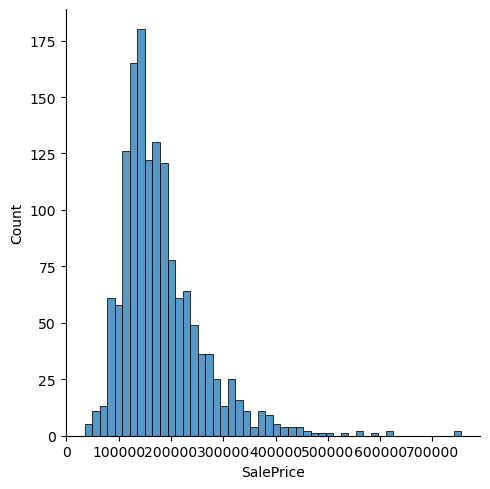

In [13]:
# House price distribution
print(train_data['SalePrice'].describe())
sns.displot(train_data['SalePrice'], bins=50)

In [14]:
# Numerical Data Distribution
list(set(train_data.dtypes.tolist()))

[dtype('int64'), dtype('float64'), dtype('O')]

In [15]:
data_num = train_data.select_dtypes(include = ['float64', 'int64'])
data_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>],
       [<AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>],
       [<AxesSubplot:title={'center':'TotalBsmtSF'}>,
        <AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>],
       [<AxesSubplot:title={'center':'BsmtHalfBath'

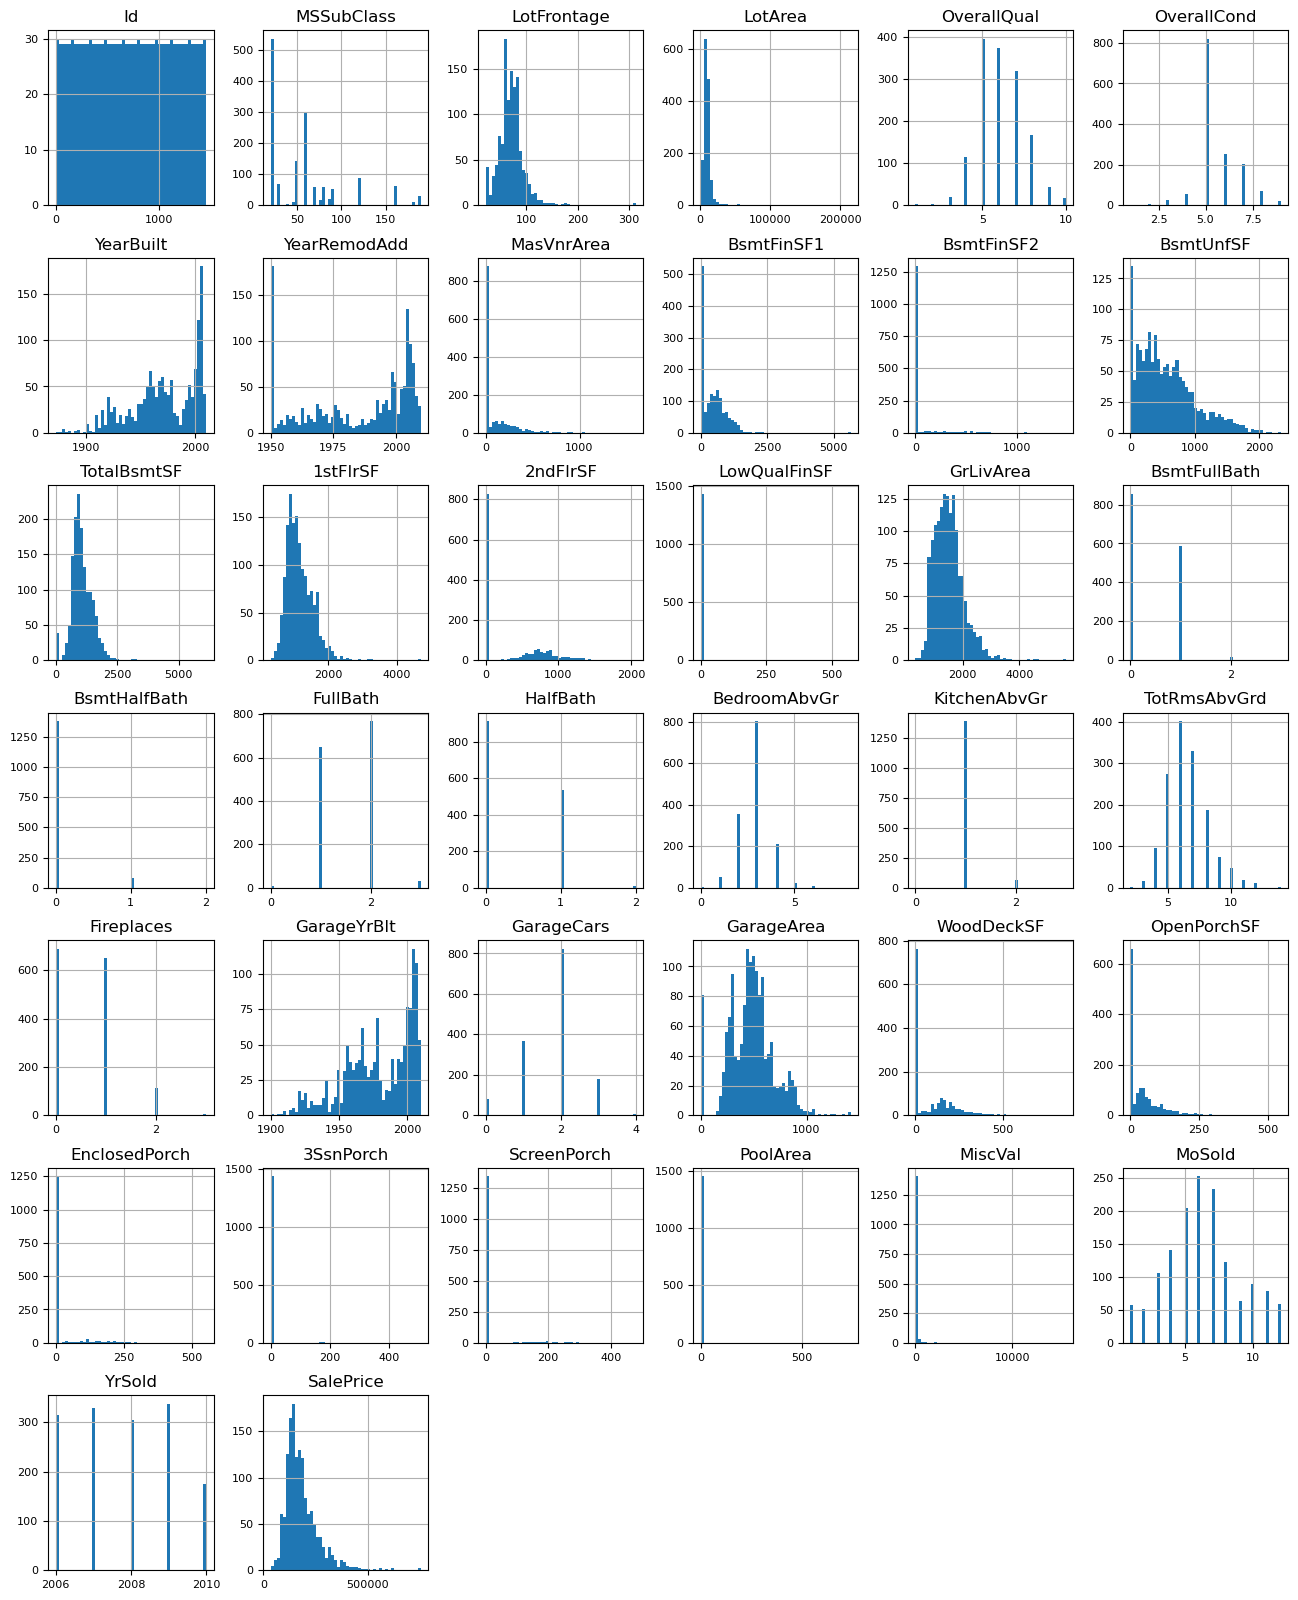

In [16]:
data_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

<AxesSubplot:>

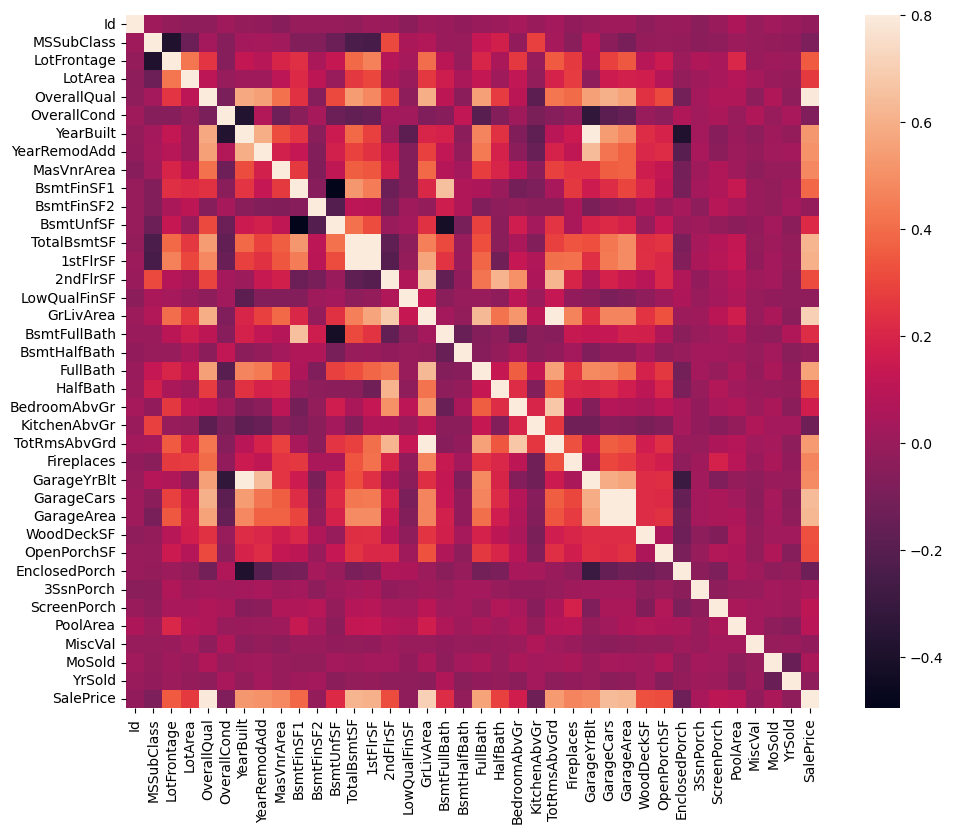

In [17]:
# Correlation Matrix
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

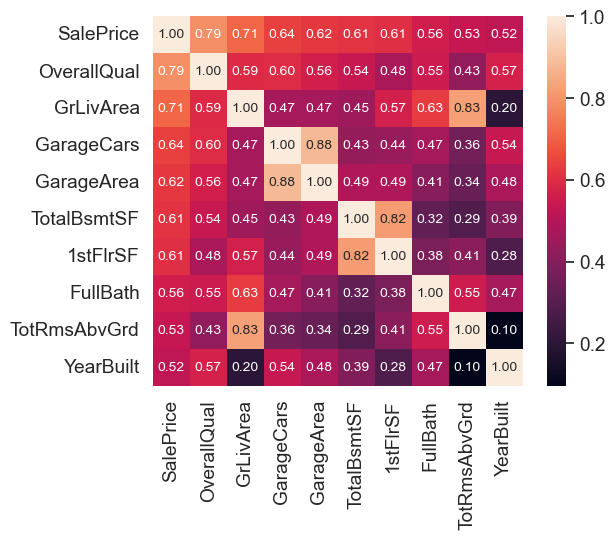

In [18]:
# SalePrice Correlation Matrix
k = 10 # number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Data Preparation 

### Data Cleaning + Preprocessing

In [19]:
# Drop columns with over 10% missing values
threshold = len(train_data) * 0.85
train_data = train_data.dropna(axis=1, thresh=threshold)

In [20]:
# Confirm columns were dropped
null_pcts = round((train_data.isnull().sum() / len(train_data)) * 100, 2)
null_pcts[null_pcts > 0].sort_values(ascending=False)

GarageType      5.55
GarageYrBlt     5.55
GarageFinish    5.55
GarageQual      5.55
GarageCond      5.55
BsmtExposure    2.60
BsmtFinType2    2.60
BsmtQual        2.53
BsmtCond        2.53
BsmtFinType1    2.53
MasVnrType      0.55
MasVnrArea      0.55
Electrical      0.07
dtype: float64

Confirmed!

### Data Normalization/Encoding (for ML models)

In [21]:
# Standardizing the data using univariate analysis -> convert data values to have a mean of 0 and s.d. of 1
# Select the 'SalePrice' column as a numpy array
saleprice_column = train_data['SalePrice'].values

# Reshape it to a 2D array
saleprice_column = saleprice_column.reshape(-1, 1)

# Scale the values using StandardScaler
scaler = StandardScaler()
saleprice_scaled = scaler.fit_transform(saleprice_column)

# Print ranges
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

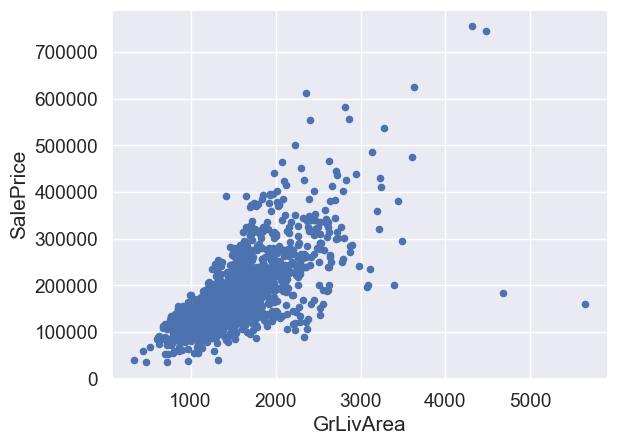

In [22]:
# Bivariate analysis
price_and_area = pd.concat([train_data['SalePrice'], train_data['GrLivArea']], axis=1)
price_and_area.plot.scatter(x='GrLivArea', y='SalePrice')

The two values with large areas and small sale prices do not follow the common trend and seem like outliers. This can be contributed to the land being priced at a lower than normal price, potentially for agriculture use. Since they are outliers, these points should be deleted.

In [23]:
# Deleting the outliers
train_data.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


In [24]:
train_data = train_data.drop(train_data[train_data['Id'] == 1299].index)
train_data = train_data.drop(train_data[train_data['Id'] == 524].index)

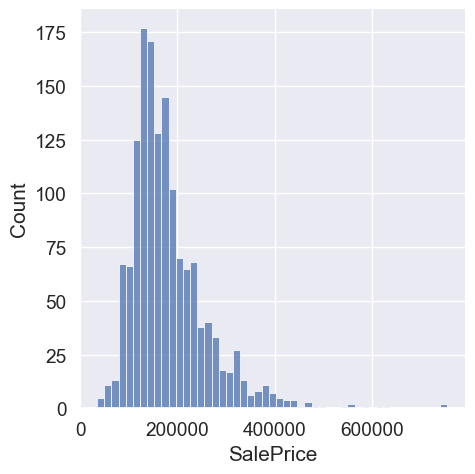

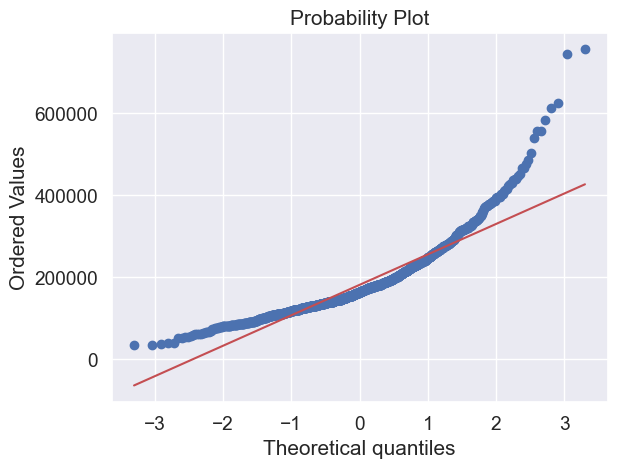

In [25]:
# Normalizing SalePrice
sns.displot(train_data['SalePrice'])
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)

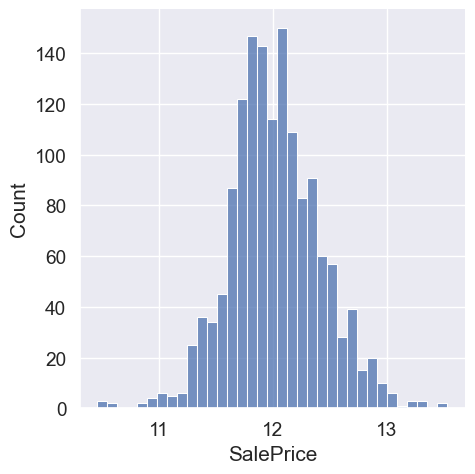

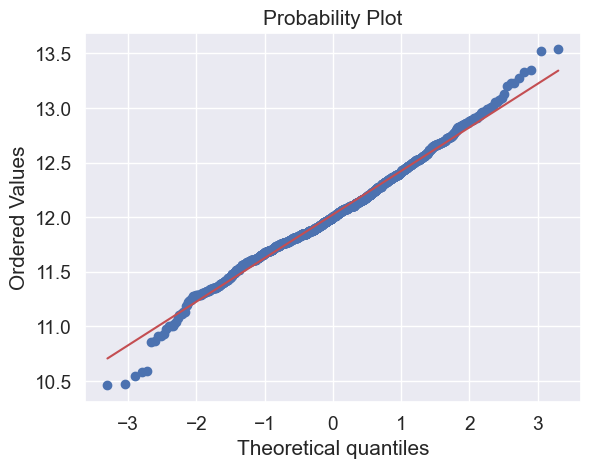

In [26]:
# Applying log transformation to solve positive skewness
train_data['SalePrice'] = np.log(train_data['SalePrice'])
sns.displot(train_data['SalePrice'])
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)

Much better looking for SalePrice!

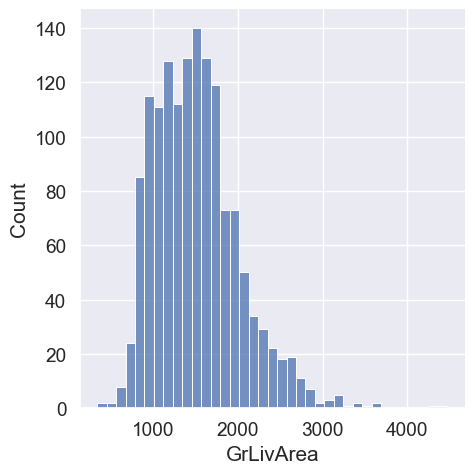

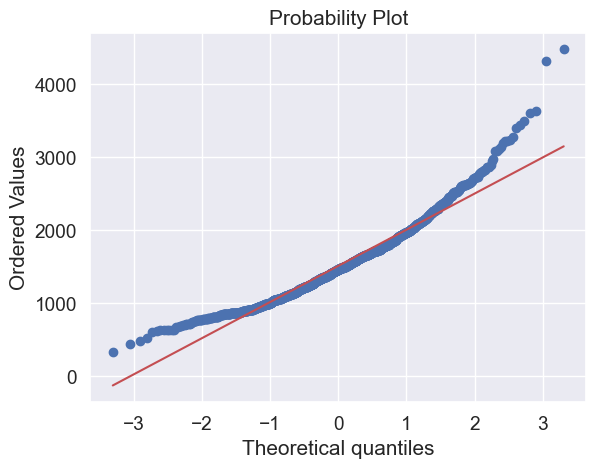

In [27]:
# Normalizing GrLivArea 
sns.displot(train_data['GrLivArea'])
fig = plt.figure()
res = stats.probplot(train_data['GrLivArea'], plot=plt)

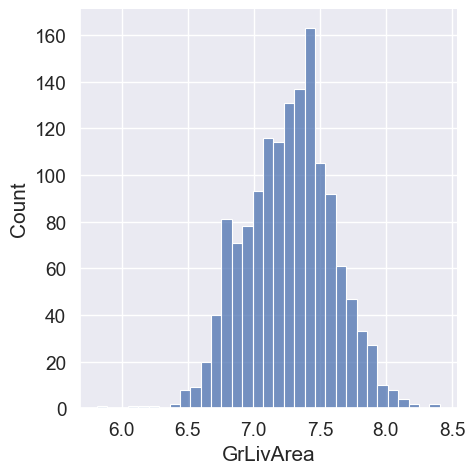

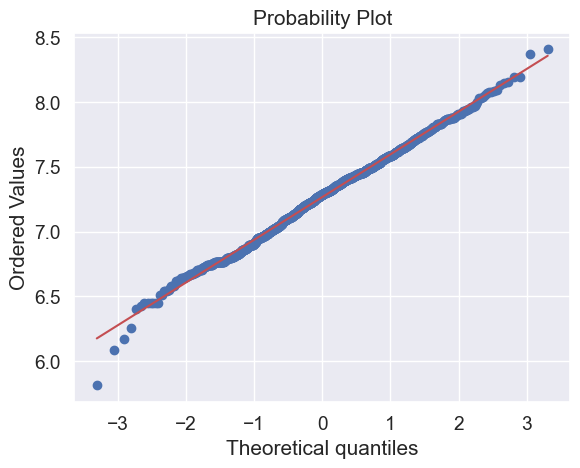

In [28]:
# GrLivArea log transformation
train_data['GrLivArea'] = np.log(train_data['GrLivArea'])
sns.displot(train_data['GrLivArea'])
fig = plt.figure()
res = stats.probplot(train_data['GrLivArea'], plot=plt)

Transformed - next variable: TotalBsmtSF

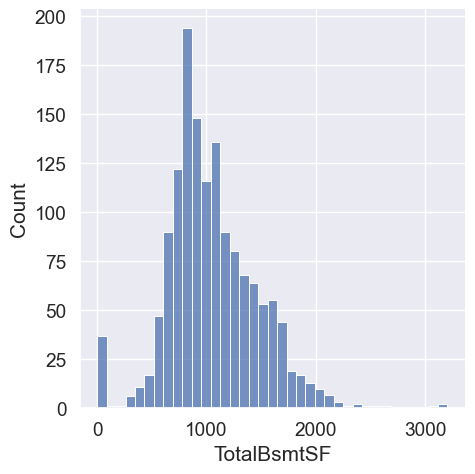

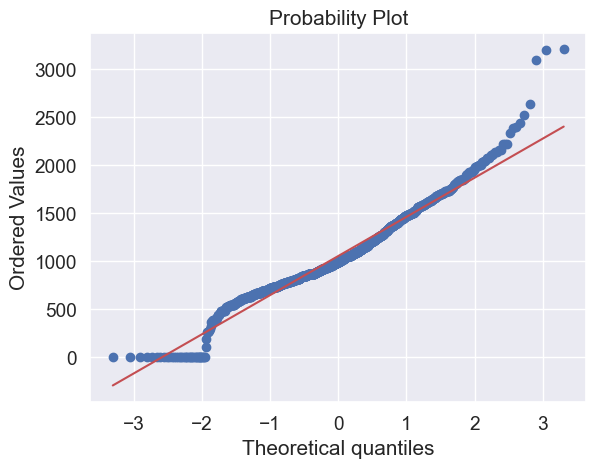

In [29]:
sns.displot(train_data['TotalBsmtSF'])
fig = plt.figure()
res = stats.probplot(train_data['TotalBsmtSF'], plot=plt)

Big issue: variable presents skewness and there are significant zero values, preventing us from doing log transformation. Instead, we need to create a binary variable for either having or not having a basement.

In [30]:
# area > 0 --> 1; area = 0 --> 0
train_data['HasBsmt'] = pd.Series(len(train_data['TotalBsmtSF']), index=train_data.index)
train_data['HasBsmt'] = 0 
train_data.loc[train_data['TotalBsmtSF']>0, 'HasBsmt'] = 1

In [31]:
train_data.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HasBsmt
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,12.247694,1
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,12.109011,1
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,12.317167,1
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,2,2006,WD,Abnorml,11.849398,1
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,12.429216,1


/Users/michaeldisanto/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


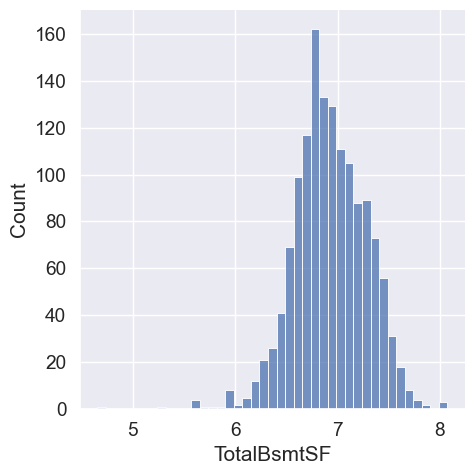

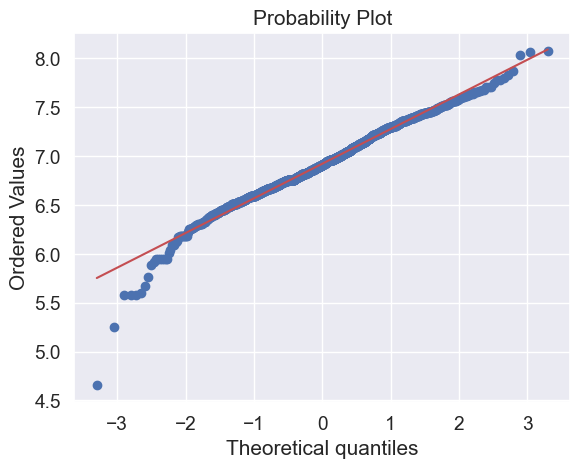

In [32]:
# Transform data to all non-zero observations
train_data.loc[train_data['HasBsmt']==1,'TotalBsmtSF'] = np.log(train_data['TotalBsmtSF'])
sns.displot(train_data[train_data['TotalBsmtSF']>0]['TotalBsmtSF'])
fig = plt.figure()
res = stats.probplot(train_data[train_data['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

### Feature Engineering

In [34]:
# Drop ID column for training
train_data = train_data.drop(columns='Id', axis=1)

### Splitting the Data

In [35]:
# From House Prices Prediction using TFDF notebook
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(train_data)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1041 examples in training, 417 examples in testing.


## Modeling
* Select machine learning algorithms that are appropriate for your problem.
* Train and evaluate models.
* Hyperparameter tuning.
* Cross-validation if applicable.
* Performance metrics (e.g., accuracy, F1-score, RMSE, etc.).

### Model Selection

In [36]:
# Convert from pandas dataset format to Tensforflow dataset format
train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label='SalePrice', task = tfdf.keras.Task.REGRESSION)
valid_data = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label='SalePrice', task = tfdf.keras.Task.REGRESSION)

/Users/michaeldisanto/opt/anaconda3/lib/python3.7/site-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)
2023-09-19 16:11:29.182307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
# List of available models
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [38]:
# Create a Random Forest
rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
rf.compile(metrics=['mse'])

Use /var/folders/gf/rytq_8w11qq14gmd_q1816kr0000gn/T/tmppar6cg8_ as temporary training directory


### Model Training and Evaluation

In [39]:
rf.fit(x=train_data)

Reading training dataset...


Training dataset read in 0:00:04.882855. Found 1041 examples.
Training model...


[INFO kernel.cc:1176] Loading model from path /var/folders/gf/rytq_8w11qq14gmd_q1816kr0000gn/T/tmppar6cg8_/model/ with prefix 79779c28783b4bc7


Model trained in 0:00:01.251538
Compiling model...


[INFO decision_forest.cc:639] Model loaded with 300 root(s), 99102 node(s), and 69 input feature(s).
[INFO abstract_model.cc:1249] Engine "RandomForestOptPred" built
[INFO kernel.cc:1022] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


### Evaluating the Model

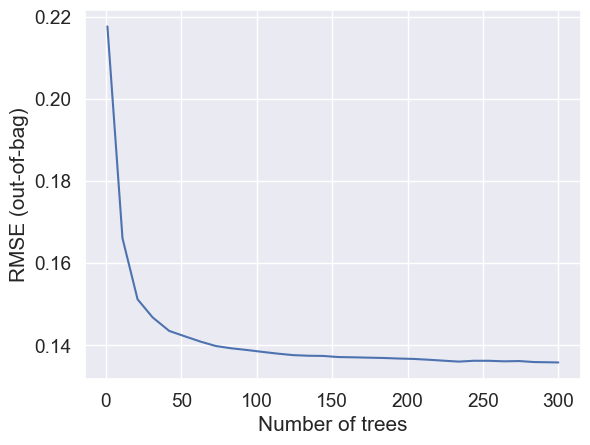

In [42]:
# Using Out of bag (OOB) score to validate RF model
# Training logs show Root Mean Squared Error
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [44]:
# Evaluating using the valid_data testing data
evaluation = rf.evaluate(x=valid_data,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - mse: 0.0192
loss: 0.0000
mse: 0.0192


### Variable Importances

In [46]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1041, accuracy=None, loss=None, rmse=0.13578215819456319, ndcg=None, aucs=None, auuc=None, qini=None)

In [47]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
    print("\t", importance)

Available variable importances:
	 NUM_NODES
	 MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT


In [48]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #58), 112.0),
 ("ExterQual" (4; #21), 54.0),
 ("Neighborhood" (4; #55), 48.0),
 ("GrLivArea" (1; #35), 33.0),
 ("YearBuilt" (1; #71), 14.0),
 ("FullBath" (1; #26), 9.0),
 ("KitchenQual" (4; #42), 8.0),
 ("GarageYrBlt" (1; #34), 7.0),
 ("GarageCars" (1; #29), 5.0),
 ("GarageArea" (1; #28), 4.0),
 ("GarageFinish" (4; #31), 4.0),
 ("TotalBsmtSF" (1; #68), 1.0),
 ("YearRemodAdd" (1; #72), 1.0)]

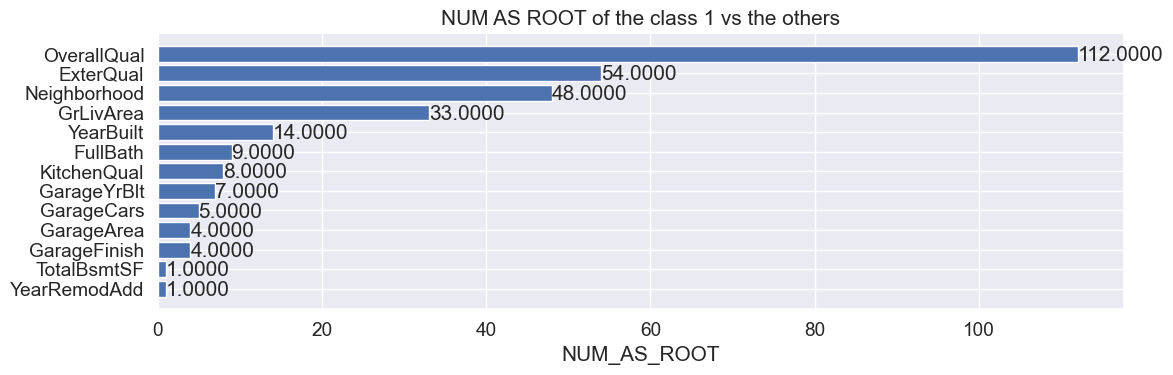

In [49]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

## Results and Discussion

### Analysis and Modeling Results

Through training the Random Forest model on standardized housing price data, we were able to predict housing prices with relatively low error. The model achieved a mean squared error of 0.0192, showing that the model was very close to predicting correct housing prices. 

Additionally, we uncovered some of the more accurate variables in predicting house prices. The top three variables in predicting house prices, starting with the best predictor, are OverallQual, ExterQual, and Neighborhood. In analyzing these results, it makes sense that these are good predictors of house prices. For example, a good neighborhood should correspond with a higher house price. This confirms that our model achieved a relatively high accuracy.

### Challenges and Future Work

As an beginner project in my journey into machine/deep learning, this project was a great introduction to the capabilities of applying decision trees to structured data. Some of the challenges were figuring out how to engineer the data to account for data exploration discoveries. That was where the comprehensive-data-exploration-with-python notebook was a great help, and I couldn't have succeeded without the work done in this notebook.

In the future, I am looking forward to exploring the rest of the TensorFlow Decision Forests library for regression, as well as classification, ranking, and uplifting. Additionally, I would like to see how improving the feature engineering step could improve the model's success. Overall, I am very happy with how this project formulated, and I will look back at this project as a launch pad for my data science career.

## References
* https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python (for exploratory data analysis + preprocessing)
* https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques (for model training)

## License

MIT License

Copyright (c) 2023 Michael DiSanto

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.